In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.autograd import Variable
from IPython.core.debugger import set_trace
import cv2
from PIL import Image

In [2]:
torch.manual_seed(0);

In [63]:
normalize = torchvision.transforms.Normalize((0.4895832, 0.4546405, 0.41594946), 
                                 (0.2520022, 0.24522494, 0.24728711))
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               normalize])

# transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder(
                    root='./data/trainset/',
                    transform=transforms
                    )

test_data = torchvision.datasets.ImageFolder(
                    root= './data/test/', 
                    transform=transforms)

dataset_ratio = np.array([95, 5])/100

sizes = [int(x*len(data)) for x in dataset_ratio]
sizes[0] += len(data) - sum(sizes)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset=data, lengths=sizes)

train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=128,
                    num_workers=2,
                    shuffle=True
                    )

valid_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=128,
                    num_workers=2,
                    shuffle=True
                    )

test_loader = torch.utils.data.DataLoader(test_data)
classes = ('Cat', 'Dog')

In [17]:
def flaotTensorToImage(img, mean=0, std=1):
    """convert a tensor to an image"""
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = (img*std+ mean)*255
    img = img.astype(np.uint8)    
    return img  

tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1])
Batch shape: (128, 3, 64, 64)
(64, 64, 3)


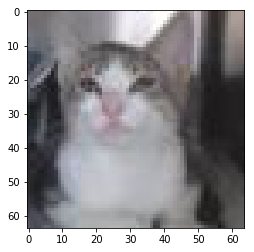

In [62]:
imgs, steering_angle = next(iter(train_loader))
print (steering_angle)
print('Batch shape:',imgs.numpy().shape)
im = imgs[1].numpy()
im2display = im.transpose((1,2,0))
print(im2display.shape)
plt.imshow(im2display, interpolation='nearest')
plt.show()
# plt.imshow(imgs.numpy()[0,:,:,:])
# plt.show()
# plt.imshow(imgs.numpy()[-1,:,:,:])
# plt.show()

In [5]:
## get the mean and variance of our dataset for normalization

train = trainloader.__iter__().next()[0]
print (len(trainloader.dataset))
print('Mean: {}'.format(np.mean(train.numpy(), axis=(0, 2, 3))))
print('STD: {}'.format(np.std(train.numpy(), axis=(0, 2, 3))))

In [64]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [65]:
# learning_rate = 1e-3
lr0 = 0.1
optim = 'sgd'
num_epochs = 100
store_every = 200
best_acc = torch.FloatTensor([0])
start_epoch = 0

In [66]:
def dropout(p=None, dim=None, method='standard'):
    if method == 'standard':
        return nn.Dropout(p)
    elif method == 'gaussian':
        return GaussianDropout(p/(1-p))
    elif method == 'variational':
        return VariationalDropout(p/(1-p), dim)

In [68]:
class GaussianDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(GaussianDropout, self).__init__()
        self.alpha = torch.Tensor([alpha])
        
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            # N(1, alpha)
            epsilon = torch.randn(x.size()) * self.alpha + 1

            epsilon = Variable(epsilon)
            if x.is_cuda:
                epsilon = epsilon.cuda()

            return x * epsilon
        else:
            return x

In [84]:
class XavierClassifier(nn.Module):
    def __init__(self):
        super(XavierClassifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            dropout(0.5, 16,'gaussian'),
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
             # Layer 7
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 8
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            # Layer 9
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            dropout(0.5, 512,'gaussian'),
            
        )
        self.net = nn.Linear(512, 512)
        self.net = nn.Linear(512, 2)
        self.init_weights()
    def forward(self, x):
        return self.net(self.conv(x).squeeze())
    
    def init_weights(self):
        for m in self.conv:
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        if type(self.net) == nn.Linear:
            nn.init.xavier_uniform_(self.net.weight)
            self.net.bias.data.fill_(0.01)

In [85]:
classifiers = ['ResidualClassifier', "VanilaCNN", "XavierClassifier" ]
my_classifier = 'XavierClassifier'

if my_classifier=='ResidualClassifier':
    model = ResidualClassifier()
elif my_classifier=='VanilaCNN':
    model = VanilaCNN() 
elif my_classifier=='XavierClassifier':
    model = XavierClassifier() 
    
learning_rate = 0.1

if cuda_available:
    model = model.cuda()
if optim == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#     optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.95)
elif optim == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [86]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
   GaussianDropout-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
             ReLU-10          [-1, 128, 32, 32]               0
        MaxPool2d-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [87]:
def adjust_lr(optimizer, epoch, total_epochs, loss):
    mean_loss = np.mean(loss[epoch-2:-1])
    if np.float(loss[epoch]) < np.float(mean_loss):
        lr = lr0 * (0.5 ** (epoch+1 / float(total_epochs)))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [88]:
# Keep only a single checkpoint, the best over test accuracy.
def save_checkpoint(state, is_best, filename='./output/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [89]:
class Trainer():
    def __init__(self,  model, optimizer, criterion, train_loader, valid_loader):
        super(Trainer, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
    def evaluate(self, dataset_loader, criterion):
        LOSSES = 0
        COUNTER = 0
        for batch in dataset_loader:
            optimizer.zero_grad()

            x, y = batch
    #             x = x.view(-1,1,28,28)
            y = y.view(-1)
            if cuda_available:
                x = x.cuda()
                y = y.cuda()

            loss = criterion(model(x), y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            COUNTER += n

        return LOSSES / float(COUNTER)
    
    def accuracy(self, proba, y):
        correct = torch.eq(proba.max(1)[1], y).sum().type(torch.FloatTensor)
        return correct / y.size(0)
    
#     def adjust_lr(self, optimizer, epoch, total_epochs):
#         lr = lr0 * (0.5 ** (epoch / float(total_epochs)))
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr
    
    def train_model(self):
        c = 0
        LOSSES = 0
        lv = 0
        av = 0
        loss_val = []
        COUNTER = 0
        ITERATIONS = 0
        learning_curve_nll_train = list()
        learning_curve_nll_test = list()
        learning_curve_acc_train = list()
        learning_curve_acc_test = list()
        for e in range(num_epochs):    
            for batch in train_loader:
                optimizer.zero_grad()
                x, y = batch
    #             x = x.view(-1,1,28,28)
                y = y.view(-1)
                if cuda_available:
                    x = x.cuda()
                    y = y.cuda()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

                n = y.size(0)
                LOSSES += loss.sum().data.cpu().numpy() * n
                COUNTER += n
                ITERATIONS += 1
                if ITERATIONS%(store_every/5) == 0:
                    avg_loss = LOSSES / float(COUNTER)
                    LOSSES = 0
                    COUNTER = 0
                    print(" Iteration {}: TRAIN {:.4f}".format(
                        ITERATIONS, avg_loss))

                if ITERATIONS%(store_every) == 0:     

                    train_loss = self.evaluate(train_loader, criterion)
                    learning_curve_nll_train.append(train_loss)
                    test_loss = self.evaluate(valid_loader, criterion)
                    learning_curve_nll_test.append(test_loss)

                    train_acc = self.evaluate(train_loader, self.accuracy)
                    learning_curve_acc_train.append(train_acc)
                    test_acc = self.evaluate(valid_loader, self.accuracy)
                    learning_curve_acc_test.append(test_acc)

                    print(" [Loss] TRAIN {:.4f} / TEST {:.4f}".format(
                        train_loss, test_loss))
                    print(" [ACC] TRAIN {:.4f} / TEST {:.4f}".format(
                        train_acc, test_acc))
                    lv = test_loss
                    av = test_acc
                    
                    print('=> Validation set: Accuracy: {:.4f}'.format(av))
                    acc = torch.FloatTensor([av])
                    is_best = bool(acc.numpy() > best_acc.numpy())
                    best_accuracy = torch.FloatTensor(max(acc.numpy(), best_acc.numpy()))
                    # Save checkpoint if is a new best
                    save_checkpoint({
                        'epoch': start_epoch + e + 1,
                        'state_dict': model.state_dict(),
                        'best_accuracy': best_accuracy
                    }, is_best)  
                   
            loss_val.append(lv)
#             self.adjust_lr(optimizer, e+1, num_epochs)
            c += 1    
            if (c%10 == 0):
                adjust_lr(optimizer, e, num_epochs, loss_val)

        return learning_curve_nll_train, \
               learning_curve_nll_test, \
               learning_curve_acc_train, \
               learning_curve_acc_test, 
    
trainer = Trainer(model, optimizer, criterion, train_loader, valid_loader)
nll_train, nll_test, acc_train, acc_test =  trainer.train_model()
print('Done...')

 Iteration 40: TRAIN 0.6933
 Iteration 80: TRAIN 0.6864
 Iteration 120: TRAIN 0.6836
 Iteration 160: TRAIN 0.6764
 Iteration 200: TRAIN 0.6696
 [Loss] TRAIN 0.6541 / TEST 0.6534
 [ACC] TRAIN 0.6271 / TEST 0.6236
=> Validation set: Accuracy: 0.6236
=> Saving a new best
 Iteration 240: TRAIN 0.6540


KeyboardInterrupt: 

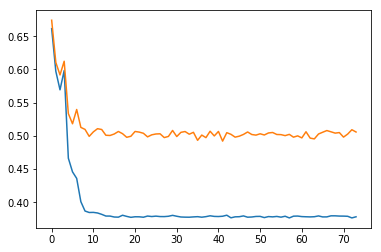

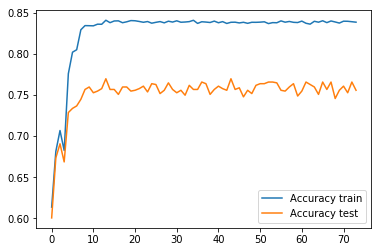

In [24]:
plt.figure(1)
plt.plot(range(len(nll_train)), nll_train, label="Loss train" )
plt.plot(range(len(nll_test)), nll_test,   label="Loss test" )
plt.figure(2)
plt.plot(range(len(acc_train)), acc_train, label="Accuracy train" )
plt.plot(range(len(acc_test)), acc_test,   label="Accuracy test" )
plt.legend()
plt.show()

In [25]:
results = [[]]
for batch_idx, (inputs, targets) in enumerate(test_loader):
    if cuda_available:
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    results = np.append(results, predicted.cpu().numpy())

results = np.int8(results)

In [49]:
df = pd.DataFrame({ 'id': range(1, len(results)+1),
                    'label': results})
df['label'].replace([0,1], ['Cat','Dog'], inplace=True)
df[df.columns].to_csv('submisstion.csv',index=False)
print('Done...')

Done...


In [2]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()

class DriveData(Dataset):
    __xs = []
    __ys = []

    def __init__(self, folder_dataset, transform=None):
        self.transform = transform
        # Open and load text file including the whole training data
        for i in range(1,5000):
            address = folder_dataset + (str(i)+".jpg")
            self.__xs.append(address)

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
        img = Image.open(self.__xs[index])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # Convert image and label to torch tensors
        img = torch.from_numpy(np.asarray(img))
        
        return img, 0

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.__xs)

In [4]:
dset_train = DriveData("./data/test/")
test_loader2 = DataLoader(dset_train, batch_size=10, shuffle=False, num_workers=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Batch shape: (10, 64, 64, 3)
(64, 64, 3)


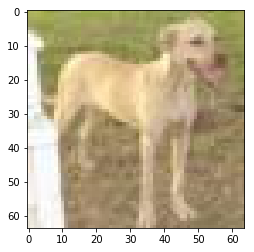

In [12]:
imgs, steering_angle = next(iter(test_loader2))
print (steering_angle)
print('Batch shape:',imgs.numpy().shape)
im = imgs[1].numpy()
im2display = im.transpose((0,1,2))
print(im2display.shape)
plt.imshow(im2display, interpolation='nearest')
plt.show()

In [10]:
results = [[]]
for batch_idx, (inputs, targets) in enumerate(test_loader2):
    if True:
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    results = np.append(results, predicted.cpu().numpy())

results = np.int8(results)

NameError: name 'model' is not defined